In [1]:
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from astropy.io import ascii
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import pandas as pd
import pprint
import sys
import operator
from scipy import optimize
from scipy.optimize import curve_fit

In [3]:
data = ascii.read("prospector_3dhst_catalog_with_UVJ_galfit.csv", format='csv')
columns = pd.read_csv('prospector_3dhst_catalog_with_UVJ_galfit.csv', index_col=0, nrows=0).columns.tolist()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(columns)
print(data)

[   'objname',
    'z',
    'logstellar_mass_median',
    'logstellar_mass_errup',
    'logstellar_mass_errdown',
    'sfr_100myr_median',
    'sfr_100myr_errup',
    'sfr_100myr_errdown',
    'logssfr_100myr_median',
    'logssfr_100myr_errup',
    'logssfr_100myr_errdown',
    'logzsol_median',
    'logzsol_errup',
    'logzsol_errdown',
    'tau_dust_median',
    'tau_dust_errup',
    'tau_dust_errdown',
    'avg_age_median',
    'avg_age_errup',
    'avg_age_errdown',
    'UV',
    'VJ',
    're',
    'dre',
    'q',
    'dq']
 col0  objname    z    logstellar_mass_median ...    dre       q        dq   
----- --------- ------ ---------------------- ... ---------- ------ ---------
    0  AEGIS_13 1.3049                10.6668 ... 0.00691672  0.486 0.0127806
    1  AEGIS_17 1.7499                10.5574 ...   0.028307   0.73 0.0504242
    2  AEGIS_19 1.0761                 9.5103 ...    0.01762 0.5641 0.0324193
    3  AEGIS_22  1.657                 9.2836 ...   0.025531 0.5383  0.20

In [70]:
redshift_data = data['z']
mass_data = data['logstellar_mass_median']
mass_errup_data = -data['logstellar_mass_median']+data['logstellar_mass_errup']
mass_errdn_data = data['logstellar_mass_median']-data['logstellar_mass_errdown']
ssfr_data = data['logssfr_100myr_median']
ssfr_errup_data = -data['logssfr_100myr_median']+data['logssfr_100myr_errup']
ssfr_errdn_data = data['logssfr_100myr_median']-data['logssfr_100myr_errdown']
radius_data = data['re']
radius_err_data = data['dre']
UVcol_data = data['UV']
VJcol_data = data['VJ']

redshift = redshift_data[(redshift_data>=0.5)&(radius_data>0.)&(radius_data<24.)&((radius_data/radius_err_data)>2.)&(mass_data/(mass_errup_data+mass_errdn_data)>1.)]
lmass = mass_data[(redshift_data>=0.5)&(radius_data>0.)&(radius_data<24.)&((radius_data/radius_err_data)>2.)&(mass_data/(mass_errup_data+mass_errdn_data)>1.)]
lmass_errup = mass_errup_data[(redshift_data>=0.5)&(radius_data>0.)&(radius_data<24.)&((radius_data/radius_err_data)>2.)&(mass_data/(mass_errup_data+mass_errdn_data)>1.)]
lmass_errdn = mass_errdn_data[(redshift_data>=0.5)&(radius_data>0.)&(radius_data<24.)&((radius_data/radius_err_data)>2.)&(mass_data/(mass_errup_data+mass_errdn_data)>1.)]
lssfr = ssfr_data[(redshift_data>=0.5)&(radius_data>0.)&(radius_data<24.)&((radius_data/radius_err_data)>2.)&(mass_data/(mass_errup_data+mass_errdn_data)>1.)]
radius = radius_data[(redshift_data>=0.5)&(radius_data>0.)&(radius_data<24.)&((radius_data/radius_err_data)>2.)&(mass_data/(mass_errup_data+mass_errdn_data)>1.)]
radius_err = radius_err_data[(redshift_data>=0.5)&(radius_data>0.)&(radius_data<24.)&((radius_data/radius_err_data)>2.)&(mass_data/(mass_errup_data+mass_errdn_data)>1.)]
UVcol = UVcol_data[(redshift_data>=0.5)&(radius_data>0.)&(radius_data<24.)&((radius_data/radius_err_data)>2.)&(mass_data/(mass_errup_data+mass_errdn_data)>1.)]
VJcol = VJcol_data[(redshift_data>=0.5)&(radius_data>0.)&(radius_data<24.)&((radius_data/radius_err_data)>2.)&(mass_data/(mass_errup_data+mass_errdn_data)>1.)]

print(len(lssfr[(lssfr<-11.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]))

comvdist = cosmo.comoving_distance(redshift)
size = comvdist*np.tan((radius*(np.pi/648000))/2)*1000
lsize = np.log10(size.value)
size_err = comvdist*np.tan((radius_err*(np.pi/648000))/2)*1000
lsize_err = np.log10(size_err.value)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [12,10]

77


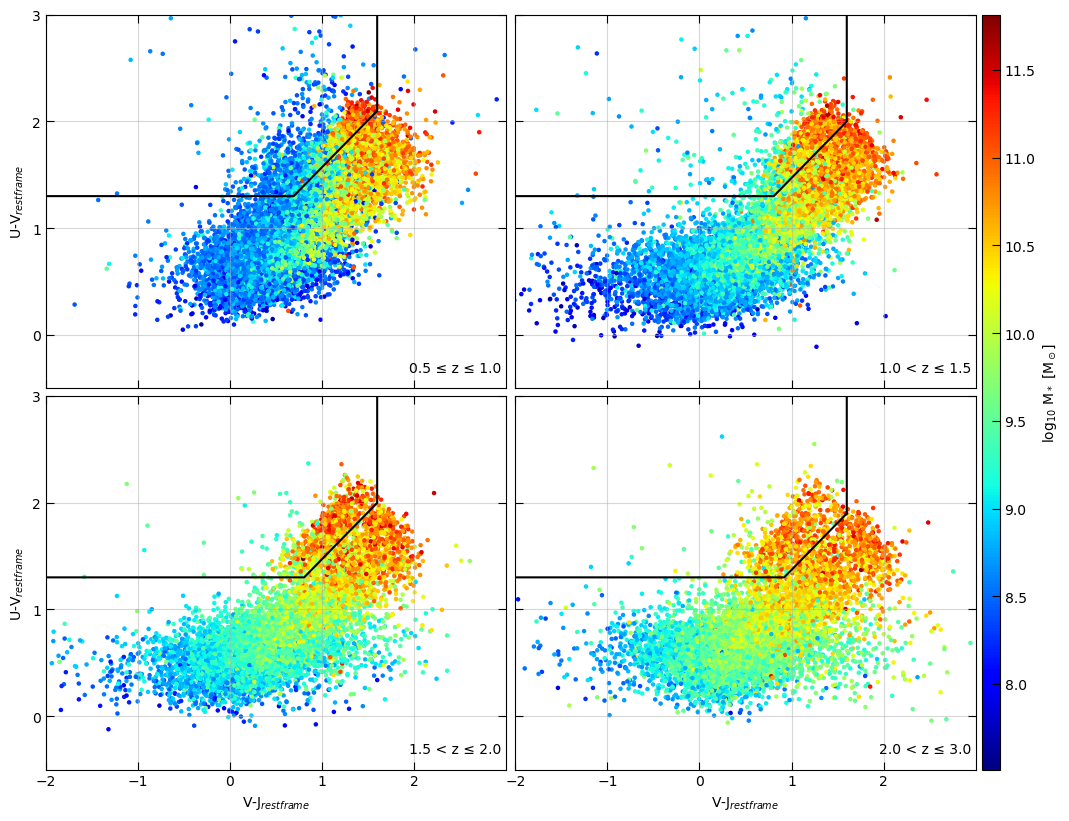

In [40]:
x1 = VJcol[redshift<=1.0]
x2 = VJcol[(redshift>1.0)&(redshift<=1.5)]
x3 = VJcol[(redshift>1.5)&(redshift<=2.0)]
x4 = VJcol[(redshift>2.0)]
y1 = UVcol[(redshift>=0.5)&(redshift<=1.0)]
y2 = UVcol[(redshift>1.0)&(redshift<=1.5)]
y3 = UVcol[(redshift>1.5)&(redshift<=2.0)]
y4 = UVcol[(redshift>2.0)]
z1 = lmass[(redshift>=0.5)&(redshift<=1.0)]
z2 = lmass[(redshift>1.0)&(redshift<=1.5)]
z3 = lmass[(redshift>1.5)&(redshift<=2.0)]
z4 = lmass[(redshift>2.0)]
cut_x1 = [-10.,0.693182,1.6,1.6]
cut_x23 = [-10.,0.806818,1.6,1.6]
cut_x4 = [-10.,0.920455,1.6,1.6]
cut_y1 = [1.3,1.3,2.098,5]
cut_y23 = [1.3,1.3,1.998,5]
cut_y4 = [1.3,1.3,1.898,5]

min_c = min(lmass)
max_c = max(lmass)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

sc = ax[0,0].scatter(x1,y1,s=5,c=z1,cmap='jet',vmin=min_c,vmax=max_c)
ax[0,1].scatter(x2,y2,s=5,c=z2,cmap='jet',vmin=min_c,vmax=max_c)
ax[1,0].scatter(x3,y3,s=5,c=z3,cmap='jet',vmin=min_c,vmax=max_c)
ax[1,1].scatter(x4,y4,s=5,c=z4,cmap='jet',vmin=min_c,vmax=max_c)

ax[0,0].plot(cut_x1,cut_y1,c="black")
ax[0,1].plot(cut_x23,cut_y23,c="black")
ax[1,0].plot(cut_x23,cut_y23,c="black")
ax[1,1].plot(cut_x4,cut_y4,c="black")

ax[0,0].tick_params(direction='in', length=6, grid_alpha=0.5)
ax[0,1].tick_params(direction='in', length=6, grid_alpha=0.5)
ax[1,0].tick_params(direction='in', length=6, grid_alpha=0.5)
ax[1,1].tick_params(direction='in', length=6, grid_alpha=0.5)

ax[0,0].xaxis.set_ticks_position('both')
ax[0,0].yaxis.set_ticks_position('both')
ax[1,0].xaxis.set_ticks_position('both')
ax[1,0].yaxis.set_ticks_position('both')
ax[0,1].xaxis.set_ticks_position('both')
ax[0,1].yaxis.set_ticks_position('both')
ax[1,1].xaxis.set_ticks_position('both')
ax[1,1].yaxis.set_ticks_position('both')

ax[0,0].set_yticks([0.0, 1.0, 2.0, 3.0])
ax[0,1].set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
ax[0,0].set_yticks([0.0, 1.0, 2.0, 3.0])
ax[1,1].set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])

ax[0,0].set_xlim(-2,3)
ax[0,1].set_xlim(-2,3)
ax[1,0].set_xlim(-2,3)
ax[1,1].set_xlim(-2,3)

ax[0,0].set_ylim(-0.5,3)
ax[0,1].set_ylim(-0.5,3)
ax[1,0].set_ylim(-0.5,3)
ax[1,1].set_ylim(-0.5,3)

ax[0,0].text(1.95, -0.35,'0.5 ≤ z ≤ 1.0')
ax[0,1].text(1.95, -0.35,'1.0 < z ≤ 1.5')
ax[1,0].text(1.95, -0.35,'1.5 < z ≤ 2.0')
ax[1,1].text(1.95, -0.35,'2.0 < z ≤ 3.0')

ax[1,0].set_xlabel('V-J$_{restframe}$')
ax[1,1].set_xlabel('V-J$_{restframe}$')

ax[0,0].set_ylabel('U-V$_{restframe}$')
ax[1,0].set_ylabel('U-V$_{restframe}$')

ax[0,0].grid(True,'minor',alpha=0.3)
ax[0,1].grid(True,'minor',alpha=0.3)
ax[1,0].grid(True,'minor',alpha=0.3)
ax[1,1].grid(True,'minor',alpha=0.3)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

cbar_ax = fig.add_axes([0.905, 0.125, 0.015, 0.755])
cbar = fig.colorbar(sc, cax=cbar_ax)

cbar
cbar.ax.set_ylabel('log$_{10}$ M$_*$ [M$_\odot$]')
cbar.ax.tick_params(direction='in', length=6)

plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.show()

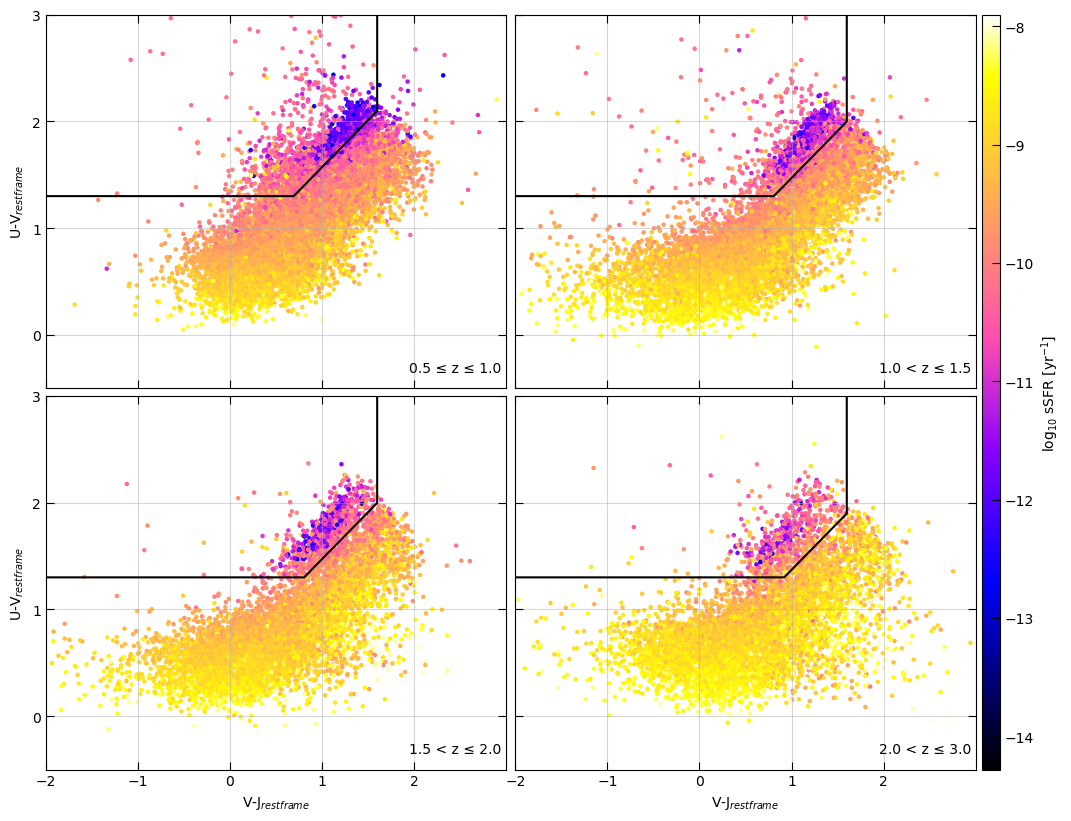

In [43]:
x1 = VJcol[redshift<=1.0]
x2 = VJcol[(redshift>1.0)&(redshift<=1.5)]
x3 = VJcol[(redshift>1.5)&(redshift<=2.0)]
x4 = VJcol[(redshift>2.0)]
y1 = UVcol[(redshift>=0.5)&(redshift<=1.0)]
y2 = UVcol[(redshift>1.0)&(redshift<=1.5)]
y3 = UVcol[(redshift>1.5)&(redshift<=2.0)]
y4 = UVcol[(redshift>2.0)]
z1 = lssfr[(redshift>=0.5)&(redshift<=1.0)]
z2 = lssfr[(redshift>1.0)&(redshift<=1.5)]
z3 = lssfr[(redshift>1.5)&(redshift<=2.0)]
z4 = lssfr[(redshift>2.0)]
cut_x1 = [-10.,0.693182,1.6,1.6]
cut_x23 = [-10.,0.806818,1.6,1.6]
cut_x4 = [-10.,0.920455,1.6,1.6]
cut_y1 = [1.3,1.3,2.098,5]
cut_y23 = [1.3,1.3,1.998,5]
cut_y4 = [1.3,1.3,1.898,5]

min_c = min(lssfr)
max_c = max(lssfr)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

sc = ax[0,0].scatter(x1,y1,s=5,c=z1,cmap='gnuplot2',vmin=min_c,vmax=max_c)
ax[0,1].scatter(x2,y2,s=5,c=z2,cmap='gnuplot2',vmin=min_c,vmax=max_c)
ax[1,0].scatter(x3,y3,s=5,c=z3,cmap='gnuplot2',vmin=min_c,vmax=max_c)
ax[1,1].scatter(x4,y4,s=5,c=z4,cmap='gnuplot2',vmin=min_c,vmax=max_c)

ax[0,0].plot(cut_x1,cut_y1,c="black")
ax[0,1].plot(cut_x23,cut_y23,c="black")
ax[1,0].plot(cut_x23,cut_y23,c="black")
ax[1,1].plot(cut_x4,cut_y4,c="black")

ax[0,0].tick_params(direction='in', length=6, grid_alpha=0.5)
ax[0,1].tick_params(direction='in', length=6, grid_alpha=0.5)
ax[1,0].tick_params(direction='in', length=6, grid_alpha=0.5)
ax[1,1].tick_params(direction='in', length=6, grid_alpha=0.5)

ax[0,0].xaxis.set_ticks_position('both')
ax[0,0].yaxis.set_ticks_position('both')
ax[1,0].xaxis.set_ticks_position('both')
ax[1,0].yaxis.set_ticks_position('both')
ax[0,1].xaxis.set_ticks_position('both')
ax[0,1].yaxis.set_ticks_position('both')
ax[1,1].xaxis.set_ticks_position('both')
ax[1,1].yaxis.set_ticks_position('both')

ax[0,0].set_yticks([0.0, 1.0, 2.0, 3.0])
ax[0,1].set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
ax[0,0].set_yticks([0.0, 1.0, 2.0, 3.0])
ax[1,1].set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])

ax[0,0].set_xlim(-2,3)
ax[0,1].set_xlim(-2,3)
ax[1,0].set_xlim(-2,3)
ax[1,1].set_xlim(-2,3)

ax[0,0].set_ylim(-0.5,3)
ax[0,1].set_ylim(-0.5,3)
ax[1,0].set_ylim(-0.5,3)
ax[1,1].set_ylim(-0.5,3)

ax[0,0].text(1.95, -0.35,'0.5 ≤ z ≤ 1.0')
ax[0,1].text(1.95, -0.35,'1.0 < z ≤ 1.5')
ax[1,0].text(1.95, -0.35,'1.5 < z ≤ 2.0')
ax[1,1].text(1.95, -0.35,'2.0 < z ≤ 3.0')

ax[1,0].set_xlabel('V-J$_{restframe}$')
ax[1,1].set_xlabel('V-J$_{restframe}$')

ax[0,0].set_ylabel('U-V$_{restframe}$')
ax[1,0].set_ylabel('U-V$_{restframe}$')

ax[0,0].grid(True,'minor',alpha=0.1)
ax[0,1].grid(True,'minor',alpha=0.1)
ax[1,0].grid(True,'minor',alpha=0.1)
ax[1,1].grid(True,'minor',alpha=0.1)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

cbar_ax = fig.add_axes([0.905, 0.125, 0.015, 0.755])
cbar = fig.colorbar(sc, cax=cbar_ax)

cbar
cbar.ax.set_ylabel('log$_{10}$ sSFR [yr$^{-1}$]')
cbar.ax.tick_params(direction='in', length=6)

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

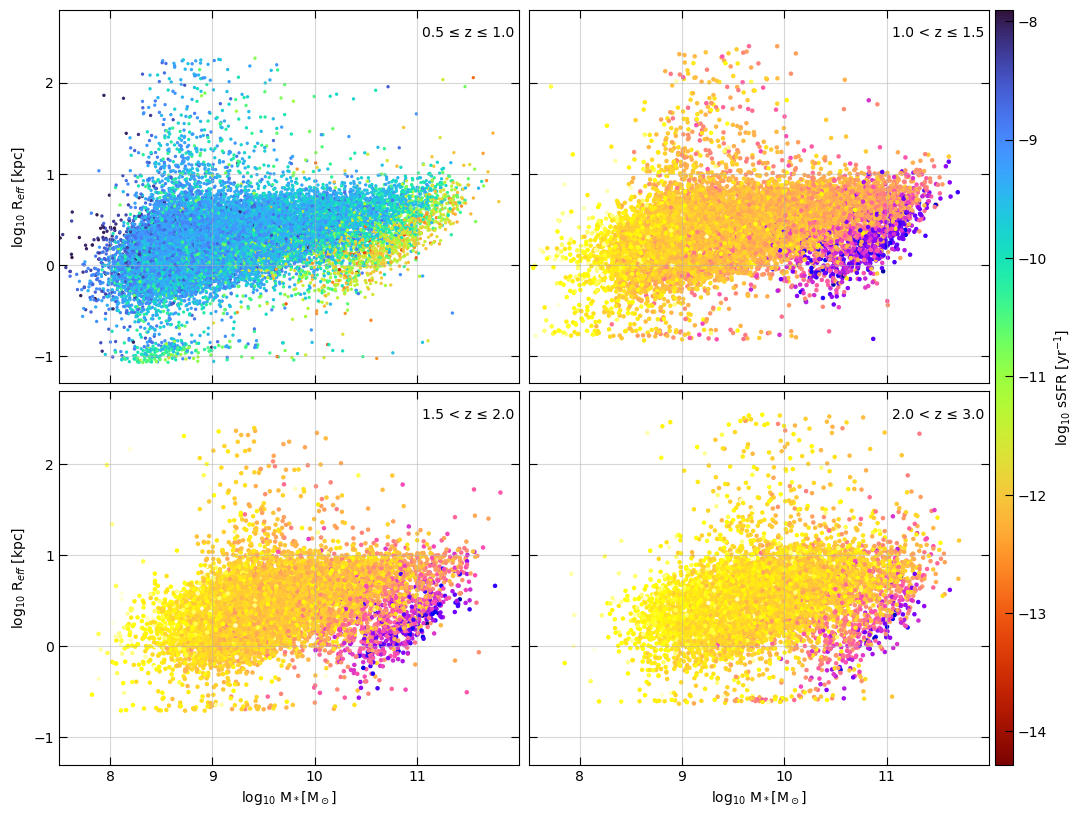

In [77]:
x1 = lmass[(redshift>=0.5)&(redshift<=1.0)]
x2 = lmass[(redshift>1.0)&(redshift<=1.5)]
x3 = lmass[(redshift>1.5)&(redshift<=2.0)]
x4 = lmass[(redshift>2.0)]
y1 = lsize[(redshift>=0.5)&(redshift<=1.0)]
y2 = lsize[(redshift>1.0)&(redshift<=1.5)]
y3 = lsize[(redshift>1.5)&(redshift<=2.0)]
y4 = lsize[(redshift>2.0)]
z1 = lssfr[(redshift>=0.5)&(redshift<=1.0)]
z2 = lssfr[(redshift>1.0)&(redshift<=1.5)]
z3 = lssfr[(redshift>1.5)&(redshift<=2.0)]
z4 = lssfr[(redshift>2.0)]
e1 = lsize_err[(redshift>=0.5)&(redshift<=1.0)]
e2 = lsize_err[(redshift>1.0)&(redshift<=1.5)]
e3 = lsize_err[(redshift>1.5)&(redshift<=2.0)]
e4 = lsize_err[(redshift>2.0)]

min_c = min(lssfr)
max_c = max(lssfr)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

sc = ax[0,0].scatter(x1,y1,s=2,c=z1,cmap='turbo_r',vmin=min_c,vmax=max_c)
ax[0,1].scatter(x2,y2,s=5,c=z2,cmap='gnuplot2',vmin=min_c,vmax=max_c)
ax[1,0].scatter(x3,y3,s=5,c=z3,cmap='gnuplot2',vmin=min_c,vmax=max_c)
ax[1,1].scatter(x4,y4,s=5,c=z4,cmap='gnuplot2',vmin=min_c,vmax=max_c)

#ax[0,0].errorbar(x1,y1,yerr=e1,fmt='none',c='blue',alpha=0.5)
#ax[0,1].errorbar(x2,y2,yerr=e2,fmt='none',c='blue',alpha=0.5)
#ax[1,0].errorbar(x3,y3,yerr=e3,fmt='none',c='blue',alpha=0.5)
#ax[1,1].errorbar(x4,y4,yerr=e4,fmt='none',c='blue',alpha=0.5)

ax[0,0].tick_params(direction='in', length=6, grid_alpha=0.5)
ax[0,1].tick_params(direction='in', length=6, grid_alpha=0.5)
ax[1,0].tick_params(direction='in', length=6, grid_alpha=0.5)
ax[1,1].tick_params(direction='in', length=6, grid_alpha=0.5)

#ax[0,0].set_yticks([10e-1, 10e0, 10e1])
#ax[0,1].set_xticks([10e9, 10e10])
#ax[0,1].set_yticks([10e-1, 10e0, 10e1])
#ax[1,1].set_xticks([10e9, 10e10])

ax[0,0].xaxis.set_ticks_position('both')
ax[0,0].yaxis.set_ticks_position('both')
ax[1,0].xaxis.set_ticks_position('both')
ax[1,0].yaxis.set_ticks_position('both')
ax[0,1].xaxis.set_ticks_position('both')
ax[0,1].yaxis.set_ticks_position('both')
ax[1,1].xaxis.set_ticks_position('both')
ax[1,1].yaxis.set_ticks_position('both')

ax[0,0].set_yticks([-1,0, 1, 2])
ax[0,1].set_xticks([8, 9, 10, 11])
ax[0,0].set_yticks([-1,0, 1, 2])
ax[1,1].set_xticks([8, 9, 10, 11])

ax[0,0].set_xlim(7.5,12)
ax[0,1].set_xlim(7.5,12)
ax[1,0].set_xlim(7.5,12)
ax[1,1].set_xlim(7.5,12)

ax[0,0].set_ylim(-1.3,2.8)
ax[0,1].set_ylim(-1.3,2.8)
ax[1,0].set_ylim(-1.3,2.8)
ax[1,1].set_ylim(-1.3,2.8)

ax[0,0].text(11.05, 2.5,'0.5 ≤ z ≤ 1.0')
ax[0,1].text(11.05, 2.5,'1.0 < z ≤ 1.5')
ax[1,0].text(11.05, 2.5,'1.5 < z ≤ 2.0')
ax[1,1].text(11.05, 2.5,'2.0 < z ≤ 3.0')

ax[1,0].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
ax[1,1].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')

ax[0,0].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
ax[1,0].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')

ax[0,0].grid(True,'minor',alpha=0.3)
ax[0,1].grid(True,'minor',alpha=0.3)
ax[1,0].grid(True,'minor',alpha=0.3)
ax[1,1].grid(True,'minor',alpha=0.3)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

cbar_ax = fig.add_axes([0.905, 0.125, 0.015, 0.755])
cbar = fig.colorbar(sc, cax=cbar_ax)

cbar
cbar.ax.set_ylabel('log$_{10}$ sSFR [yr$^{-1}$]')
cbar.ax.tick_params(direction='in', length=6)

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

[ 0.06464227  7.98092552  0.28837853 12.15550786] [-0.07815362 48.10643401 10.         13.        ] [-0.07330817 41.9567933   9.99999999 12.99999951] [-0.08162466  4.07567824  9.99999963 11.64921313]


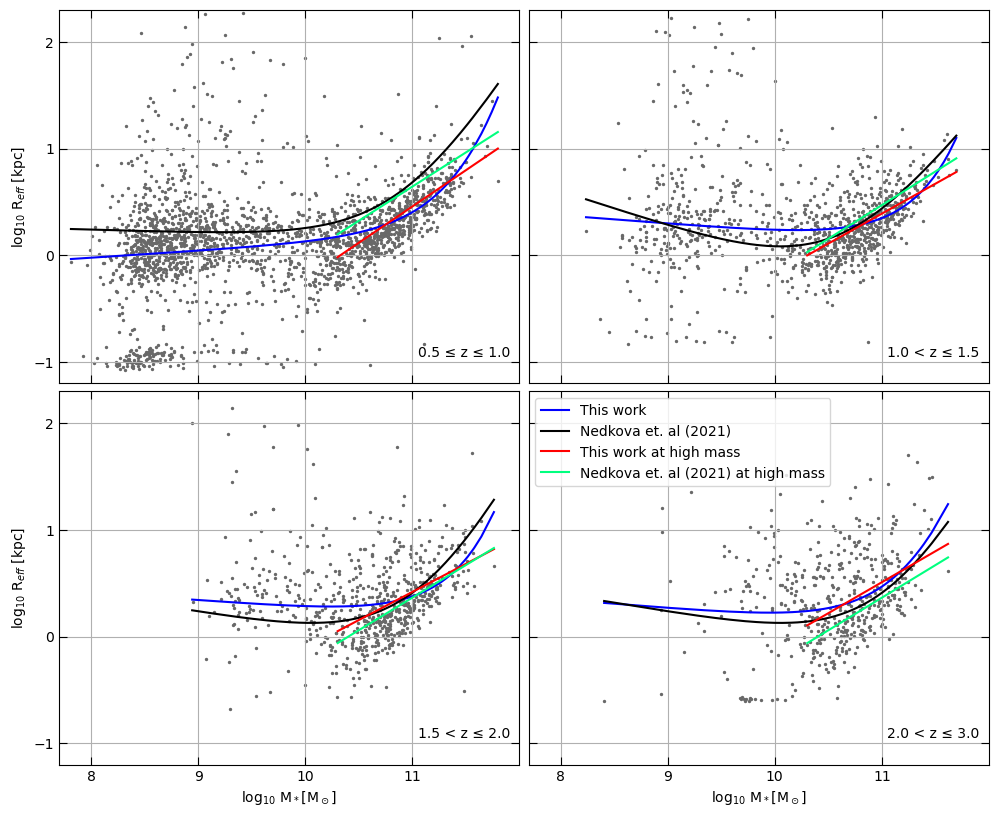

In [188]:
x1_q = lmass[(redshift>=0.5)&(redshift<=1.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
x2_q = lmass[(redshift>1.0)&(redshift<=1.5)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
x3_q = lmass[(redshift>1.5)&(redshift<=2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
x4_q = lmass[(redshift>2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
x1_qh = lmass[(redshift>=0.5)&(redshift<=1.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))&(lmass>10.3)]
x2_qh = lmass[(redshift>1.0)&(redshift<=1.5)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))&(lmass>10.3)]
x3_qh = lmass[(redshift>1.5)&(redshift<=2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))&(lmass>10.3)]
x4_qh = lmass[(redshift>2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))&(lmass>10.3)]
y1_q = lsize[(redshift>=0.5)&(redshift<=1.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
y2_q = lsize[(redshift>1.0)&(redshift<=1.5)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
y3_q = lsize[(redshift>1.5)&(redshift<=2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
y4_q = lsize[(redshift>2)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
y1_qh = lsize[(redshift>=0.5)&(redshift<=1.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))&(lmass>10.3)]
y2_qh = lsize[(redshift>1.0)&(redshift<=1.5)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))&(lmass>10.3)]
y3_qh = lsize[(redshift>1.5)&(redshift<=2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))&(lmass>10.3)]
y4_qh = lsize[(redshift>2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))&(lmass>10.3)]
z1_q = lsize_err[(redshift>=0.5)&(redshift<=1.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
z2_q = lsize_err[(redshift>1.0)&(redshift<=1.5)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
z3_q = lsize_err[(redshift>1.5)&(redshift<=2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
z4_q = lsize_err[(redshift>2)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]

def power_law(x,a,b):
    return np.log10(a)+b*np.log10(10**x)-b*np.log10(5e10)
def double_power_law(x,a,b,y,d):
    return np.log10(y)+a*np.log10(10**x)+(b-a)*np.log10(10**(x-d)+1)

x0_highmass =[10**0.45,0.64]
bounds_highmass = ([10**-0.5,0],[10**2,2])
x0_allmass =[-0.03,1.6,10**0.48,10.95]
bounds_allmass = ([-2,0,10**-10,9],[2,10**10,10,13])

p1_q,sig_1q = curve_fit(f=double_power_law, xdata=x1_q, ydata=y1_q, p0=x0_allmass, bounds=bounds_allmass)
p2_q,sig_2q = curve_fit(f=double_power_law, xdata=x2_q, ydata=y2_q, p0=x0_allmass, bounds=bounds_allmass)
p3_q,sig_3q = curve_fit(f=double_power_law, xdata=x3_q, ydata=y3_q, p0=x0_allmass, bounds=bounds_allmass)
p4_q,sig_4q = curve_fit(f=double_power_law, xdata=x4_q, ydata=y4_q, p0=x0_allmass, bounds=bounds_allmass)
p1_qh,sig_1qh = curve_fit(f=power_law, xdata=x1_qh, ydata=y1_qh, p0=x0_highmass, bounds=bounds_highmass)
p2_qh,sig_2qh = curve_fit(f=power_law, xdata=x2_qh, ydata=y2_qh, p0=x0_highmass, bounds=bounds_highmass)
p3_qh,sig_3qh = curve_fit(f=power_law, xdata=x3_qh, ydata=y3_qh, p0=x0_highmass, bounds=bounds_highmass)
p4_qh,sig_4qh = curve_fit(f=power_law, xdata=x4_qh, ydata=y4_qh, p0=x0_highmass, bounds=bounds_highmass)

print(p1_q,p2_q,p3_q,p4_q)

y1_q_fit = double_power_law(x1_q,*p1_q)
y2_q_fit = double_power_law(x2_q,*p2_q)
y3_q_fit = double_power_law(x3_q,*p3_q)
y4_q_fit = double_power_law(x4_q,*p4_q)
y1_qh_fit = power_law(x1_qh,*p1_qh)
y2_qh_fit = power_law(x2_qh,*p2_qh)
y3_qh_fit = power_law(x3_qh,*p3_qh)
y4_qh_fit = power_law(x4_qh,*p4_qh)
y1_qh_comp = power_law(x1_qh,10**0.45,0.64)
y2_qh_comp = power_law(x2_qh,10**0.28,0.63)
y3_qh_comp = power_law(x3_qh,10**0.18,0.61)
y4_qh_comp = power_law(x4_qh,10**0.18,0.61)
y1_qf_comp = double_power_law(x1_q,-0.03,1.60,10**0.48,10.95)
y2_qf_comp = double_power_law(x2_q,-0.33,1.25,10**3.24,10.63)
y3_qf_comp = double_power_law(x3_q,-0.17,1.84,10**1.76,11.09)
y4_qf_comp = double_power_law(x4_q,-0.17,1.84,10**1.76,11.09)

I = sorted(zip(x1_q,y1_q_fit), key = operator.itemgetter(0))
x1_q_srt, y1_q_srt = zip(*I)
K = sorted(zip(x2_q,y2_q_fit), key = operator.itemgetter(0))
x2_q_srt, y2_q_srt = zip(*K)
M = sorted(zip(x3_q,y3_q_fit), key = operator.itemgetter(0))
x3_q_srt, y3_q_srt = zip(*M)
O = sorted(zip(x4_q,y4_q_fit), key = operator.itemgetter(0))
x4_q_srt, y4_q_srt = zip(*O)

E = sorted(zip(x1_qh,y1_qh_fit), key = operator.itemgetter(0))
x1_qh_srt, y1_qh_srt = zip(*E)
F = sorted(zip(x2_qh,y2_qh_fit), key = operator.itemgetter(0))
x2_qh_srt, y2_qh_srt = zip(*F)
G = sorted(zip(x3_qh,y3_qh_fit), key = operator.itemgetter(0))
x3_qh_srt, y3_qh_srt = zip(*G)
H = sorted(zip(x4_qh,y4_qh_fit), key = operator.itemgetter(0))
x4_qh_srt, y4_qh_srt = zip(*H)

Q = sorted(zip(x1_qh,y1_qh_comp), key = operator.itemgetter(0))
x1_qh_comp, y1_qh_comp = zip(*Q)
S = sorted(zip(x2_qh,y2_qh_comp), key = operator.itemgetter(0))
x2_qh_comp, y2_qh_comp = zip(*S)
U = sorted(zip(x3_qh,y3_qh_comp), key = operator.itemgetter(0))
x3_qh_comp, y3_qh_comp = zip(*U)
W = sorted(zip(x4_qh,y4_qh_comp), key = operator.itemgetter(0))
x4_qh_comp, y4_qh_comp = zip(*W)

A = sorted(zip(x1_q,y1_qf_comp), key = operator.itemgetter(0))
x1_q_comp, y1_qf_comp = zip(*A)
B = sorted(zip(x2_q,y2_qf_comp), key = operator.itemgetter(0))
x2_q_comp, y2_qf_comp = zip(*B)
C = sorted(zip(x3_q,y3_qf_comp), key = operator.itemgetter(0))
x3_q_comp, y3_qf_comp = zip(*C)
D = sorted(zip(x4_q,y4_qf_comp), key = operator.itemgetter(0))
x4_q_comp, y4_qf_comp = zip(*D)

x1_q_srt = np.asarray(x1_q_srt)
x2_q_srt = np.asarray(x2_q_srt)
x3_q_srt = np.asarray(x3_q_srt)
x4_q_srt = np.asarray(x4_q_srt)
y1_q_srt = np.asarray(y1_q_srt)
y2_q_srt = np.asarray(y2_q_srt)
y3_q_srt = np.asarray(y3_q_srt)
y4_q_srt = np.asarray(y4_q_srt)
x1_qh_srt = np.asarray(x1_qh_srt)
x2_qh_srt = np.asarray(x2_qh_srt)
x3_qh_srt = np.asarray(x3_qh_srt)
x4_qh_srt = np.asarray(x4_qh_srt)
y1_qh_srt = np.asarray(y1_qh_srt)
y2_qh_srt = np.asarray(y2_qh_srt)
y3_qh_srt = np.asarray(y3_qh_srt)
y4_qh_srt = np.asarray(y4_qh_srt)

x1_q_comp = np.asarray(x1_q_comp)
x2_q_comp = np.asarray(x2_q_comp)
x3_q_comp = np.asarray(x3_q_comp)
x4_q_comp = np.asarray(x4_q_comp)
x1_qh_comp = np.asarray(x1_qh_comp)
x2_qh_comp = np.asarray(x2_qh_comp)
x3_qh_comp = np.asarray(x3_qh_comp)
x4_qh_comp = np.asarray(x4_qh_comp)
y1_qh_comp = np.asarray(y1_qh_comp)
y2_qh_comp = np.asarray(y2_qh_comp)
y3_qh_comp = np.asarray(y3_qh_comp)
y4_qh_comp = np.asarray(y4_qh_comp)
y1_qf_comp = np.asarray(y1_qf_comp)
y2_qf_comp = np.asarray(y2_qf_comp)
y3_qf_comp = np.asarray(y3_qf_comp)
y4_qf_comp = np.asarray(y4_qf_comp)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

ax[0,0].scatter(x1_q,y1_q,s=2,c='dimgrey')
ax[0,1].scatter(x2_q,y2_q,s=2,c='dimgrey')
ax[1,0].scatter(x3_q,y3_q,s=2,c='dimgrey')
ax[1,1].scatter(x4_q,y4_q,s=2,c='dimgrey')

ax[0,0].plot(x1_q_srt,y1_q_srt,c='blue',label='This work')
ax[0,1].plot(x2_q_srt,y2_q_srt,c='blue',label='This work')
ax[1,0].plot(x3_q_srt,y3_q_srt,c='blue',label='This work')
ax[1,1].plot(x4_q_srt,y4_q_srt,c='blue',label='This work')

ax[0,0].plot(x1_q_comp,y1_qf_comp,'',c='black',label='Nedkova et. al (2021)')
ax[0,1].plot(x2_q_comp,y2_qf_comp,'',c='black',label='Nedkova et. al (2021)')
ax[1,0].plot(x3_q_comp,y3_qf_comp,'',c='black',label='Nedkova et. al (2021)')
ax[1,1].plot(x4_q_comp,y4_qf_comp,'',c='black',label='Nedkova et. al (2021)')

ax[0,0].plot(x1_qh_srt,y1_qh_srt,c='red',label='This work at high mass')
ax[0,1].plot(x2_qh_srt,y2_qh_srt,c='red',label='This work at high mass')
ax[1,0].plot(x3_qh_srt,y3_qh_srt,c='red',label='This work at high mass')
ax[1,1].plot(x4_qh_srt,y4_qh_srt,c='red',label='This work at high mass')

ax[0,0].plot(x1_qh_comp,y1_qh_comp,'',c='springgreen',label='Nedkova et. al (2021) at high mass')
ax[0,1].plot(x2_qh_comp,y2_qh_comp,'',c='springgreen',label='Nedkova et. al (2021) at high mass')
ax[1,0].plot(x3_qh_comp,y3_qh_comp,'',c='springgreen',label='Nedkova et. al (2021) at high mass')
ax[1,1].plot(x4_qh_comp,y4_qh_comp,'',c='springgreen',label='Nedkova et. al (2021) at high mass')

#ax[0,0].set_xscale('log')
#ax[0,0].set_yscale('log')
#ax[1,0].set_xscale('log')
#ax[1,0].set_yscale('log')
#ax[0,1].set_xscale('log')
#ax[0,1].set_yscale('log')
#ax[1,1].set_xscale('log')
#ax[1,1].set_yscale('log')

ax[0,0].tick_params(which='major', direction='in', length=6)
ax[0,0].tick_params(which='minor', direction='in')
ax[1,0].tick_params(which='major', direction='in', length=6)
ax[1,0].tick_params(which='minor', direction='in')
ax[0,1].tick_params(which='major', direction='in', length=6)
ax[0,1].tick_params(which='minor', direction='in')
ax[1,1].tick_params(which='major', direction='in', length=6)
ax[1,1].tick_params(which='minor', direction='in')

ax[0,0].set_yticks([-1, 0, 1, 2])
ax[0,1].set_xticks([8,9,10,11])
ax[0,1].set_yticks([-1, 0, 1, 2])
ax[1,1].set_xticks([8,9,10,11])

ax[0,0].xaxis.set_ticks_position('both')
ax[0,0].yaxis.set_ticks_position('both')
ax[1,0].xaxis.set_ticks_position('both')
ax[1,0].yaxis.set_ticks_position('both')
ax[0,1].xaxis.set_ticks_position('both')
ax[0,1].yaxis.set_ticks_position('both')
ax[1,1].xaxis.set_ticks_position('both')
ax[1,1].yaxis.set_ticks_position('both')

ax[0,0].set_xlim(7.7,12)
ax[0,1].set_xlim(7.7,12)
ax[1,0].set_xlim(7.7,12)
ax[1,1].set_xlim(7.7,12)

ax[0,0].set_ylim(-1.2,2.3)
ax[0,1].set_ylim(-1.2,2.3)
ax[1,0].set_ylim(-1.2,2.3)
ax[1,1].set_ylim(-1.2,2.3)

ax[0,0].text(11.05,-.95,'0.5 ≤ z ≤ 1.0')
ax[0,1].text(11.05,-.95,'1.0 < z ≤ 1.5')
ax[1,0].text(11.05,-.95,'1.5 < z ≤ 2.0')
ax[1,1].text(11.05,-.95,'2.0 < z ≤ 3.0')

ax[1,0].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
ax[1,1].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')

ax[0,0].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
ax[1,0].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')

ax[0,0].grid(True,'minor',alpha=0.1)
ax[0,1].grid(True,'minor',alpha=0.1)
ax[1,0].grid(True,'minor',alpha=0.1)
ax[1,1].grid(True,'minor',alpha=0.1)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

#ax[0,0].legend()
#ax[0,1].legend()
#ax[1,0].legend()
ax[1,1].legend()

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

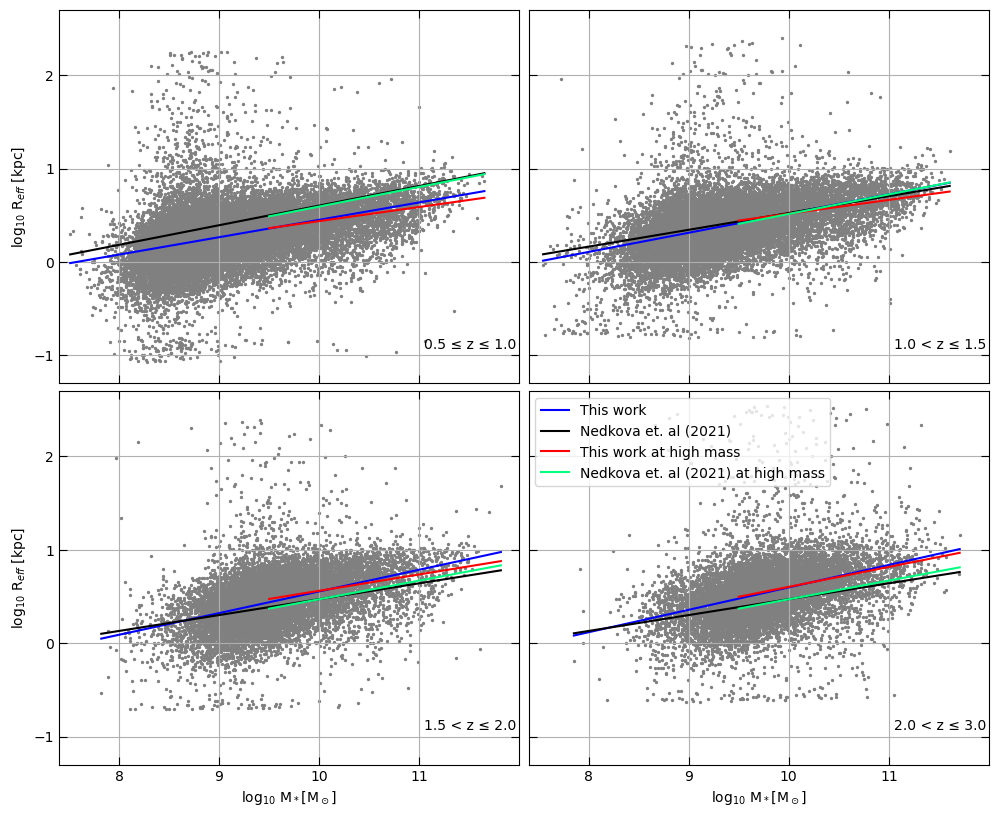

In [187]:
x1_sf = lmass[(redshift>=0.5)&(redshift<=1.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
x2_sf = lmass[(redshift>1.0)&(redshift<=1.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
x3_sf = lmass[(redshift>1.5)&(redshift<=2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
x4_sf = lmass[(redshift>2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
x1_sfh = lmass[(redshift>=0.5)&(redshift<=1.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))&(lmass>9.5)]
x2_sfh = lmass[(redshift>1.0)&(redshift<=1.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))&(lmass>9.5)]
x3_sfh = lmass[(redshift>1.5)&(redshift<=2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))&(lmass>9.5)]
x4_sfh = lmass[(redshift>2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))&(lmass>9.5)]
y1_sf = lsize[(redshift>=0.5)&(redshift<=1.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
y2_sf = lsize[(redshift>1.0)&(redshift<=1.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
y3_sf = lsize[(redshift>1.5)&(redshift<=2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
y4_sf = lsize[(redshift>2)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
y1_sfh = lsize[(redshift>=0.5)&(redshift<=1.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))&(lmass>9.5)]
y2_sfh = lsize[(redshift>1.0)&(redshift<=1.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))&(lmass>9.5)]
y3_sfh = lsize[(redshift>1.5)&(redshift<=2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))&(lmass>9.5)]
y4_sfh = lsize[(redshift>2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))&(lmass>9.5)]
z1_sf = lsize_err[(redshift>=0.5)&(redshift<=1.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
z2_sf = lsize_err[(redshift>1.0)&(redshift<=1.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
z3_sf = lsize_err[(redshift>1.5)&(redshift<=2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
z4_sf = lsize_err[(redshift>2)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]

def power_law(x,a,b):
    return np.log10(a)+b*np.log10(10**x)-b*np.log10(5e10)


x0_allmass =[10**0.75,0.21]
bounds_allmass = ([10**-0.5,0],[10**2,2])
x0_highmass =[10**0.74,0.21]
bounds_highmass = ([10**-0.5,0],[10**2,2])

p1_sf,sig_1sf = curve_fit(f=power_law, xdata=x1_sf, ydata=y1_sf, p0=x0_allmass, bounds=bounds_allmass)
p2_sf,sig_2sf = curve_fit(f=power_law, xdata=x2_sf, ydata=y2_sf, p0=x0_allmass, bounds=bounds_allmass)
p3_sf,sig_3sf = curve_fit(f=power_law, xdata=x3_sf, ydata=y3_sf, p0=x0_allmass, bounds=bounds_allmass)
p4_sf,sig_4sf = curve_fit(f=power_law, xdata=x4_sf, ydata=y4_sf, p0=x0_allmass, bounds=bounds_allmass)
p1_sfh,sig_1sfh = curve_fit(f=power_law, xdata=x1_sfh, ydata=y1_sfh, p0=x0_highmass, bounds=bounds_highmass)
p2_sfh,sig_2sfh = curve_fit(f=power_law, xdata=x2_sfh, ydata=y2_sfh, p0=x0_highmass, bounds=bounds_highmass)
p3_sfh,sig_3sfh = curve_fit(f=power_law, xdata=x3_sfh, ydata=y3_sfh, p0=x0_highmass, bounds=bounds_highmass)
p4_sfh,sig_4sfh = curve_fit(f=power_law, xdata=x4_sfh, ydata=y4_sfh, p0=x0_highmass, bounds=bounds_highmass)

y1_sf_fit = power_law(x1_sf,*p1_sf)
y2_sf_fit = power_law(x2_sf,*p2_sf)
y3_sf_fit = power_law(x3_sf,*p3_sf)
y4_sf_fit = power_law(x4_sf,*p4_sf)
y1_sfh_fit = power_law(x1_sfh,*p1_sfh)
y2_sfh_fit = power_law(x2_sfh,*p2_sfh)
y3_sfh_fit = power_law(x3_sfh,*p3_sfh)
y4_sfh_fit = power_law(x4_sfh,*p4_sfh)
y1_sf_comp = power_law(x1_sf,10**0.75,0.21)
y2_sf_comp = power_law(x2_sf,10**0.65,0.18)
y3_sf_comp = power_law(x3_sf,10**0.59,0.17)
y4_sf_comp = power_law(x4_sf,10**0.59,0.17)
y1_sfh_comp = power_law(x1_sfh,10**0.74,0.21)
y2_sfh_comp = power_law(x2_sfh,10**0.66,0.21)
y3_sfh_comp = power_law(x3_sfh,10**0.61,0.2)
y4_sfh_comp = power_law(x4_sfh,10**0.61,0.2)

I = sorted(zip(x1_sf,y1_sf_fit), key = operator.itemgetter(0))
x1_sf_srt, y1_sf_srt = zip(*I)
K = sorted(zip(x2_sf,y2_sf_fit), key = operator.itemgetter(0))
x2_sf_srt, y2_sf_srt = zip(*K)
M = sorted(zip(x3_sf,y3_sf_fit), key = operator.itemgetter(0))
x3_sf_srt, y3_sf_srt = zip(*M)
O = sorted(zip(x4_sf,y4_sf_fit), key = operator.itemgetter(0))
x4_sf_srt, y4_sf_srt = zip(*O)

E = sorted(zip(x1_sfh,y1_sfh_fit), key = operator.itemgetter(0))
x1_sfh_srt, y1_sfh_srt = zip(*E)
F = sorted(zip(x2_sfh,y2_sfh_fit), key = operator.itemgetter(0))
x2_sfh_srt, y2_sfh_srt = zip(*F)
G = sorted(zip(x3_sfh,y3_sfh_fit), key = operator.itemgetter(0))
x3_sfh_srt, y3_sfh_srt = zip(*G)
H = sorted(zip(x4_sfh,y4_sfh_fit), key = operator.itemgetter(0))
x4_sfh_srt, y4_sfh_srt = zip(*H)

Q = sorted(zip(x1_sf,y1_sf_comp), key = operator.itemgetter(0))
x1_sf_comp, y1_sf_comp = zip(*Q)
S = sorted(zip(x2_sf,y2_sf_comp), key = operator.itemgetter(0))
x2_sf_comp, y2_sf_comp = zip(*S)
U = sorted(zip(x3_sf,y3_sf_comp), key = operator.itemgetter(0))
x3_sf_comp, y3_sf_comp = zip(*U)
W = sorted(zip(x4_sf,y4_sf_comp), key = operator.itemgetter(0))
x4_sf_comp, y4_sf_comp = zip(*W)

A = sorted(zip(x1_sfh,y1_sfh_comp), key = operator.itemgetter(0))
x1_sfh_comp, y1_sfh_comp = zip(*A)
B = sorted(zip(x2_sfh,y2_sfh_comp), key = operator.itemgetter(0))
x2_sfh_comp, y2_sfh_comp = zip(*B)
C = sorted(zip(x3_sfh,y3_sfh_comp), key = operator.itemgetter(0))
x3_sfh_comp, y3_sfh_comp = zip(*C)
D = sorted(zip(x4_sfh,y4_sfh_comp), key = operator.itemgetter(0))
x4_sfh_comp, y4_sfh_comp = zip(*D)

x1_sf_srt = np.asarray(x1_sf_srt)
x2_sf_srt = np.asarray(x2_sf_srt)
x3_sf_srt = np.asarray(x3_sf_srt)
x4_sf_srt = np.asarray(x4_sf_srt)
y1_sf_srt = np.asarray(y1_sf_srt)
y2_sf_srt = np.asarray(y2_sf_srt)
y3_sf_srt = np.asarray(y3_sf_srt)
y4_sf_srt = np.asarray(y4_sf_srt)
x1_sfh_srt = np.asarray(x1_sfh_srt)
x2_sfh_srt = np.asarray(x2_sfh_srt)
x3_sfh_srt = np.asarray(x3_sfh_srt)
x4_sfh_srt = np.asarray(x4_sfh_srt)
y1_sfh_srt = np.asarray(y1_sfh_srt)
y2_sfh_srt = np.asarray(y2_sfh_srt)
y3_sfh_srt = np.asarray(y3_sfh_srt)
y4_sfh_srt = np.asarray(y4_sfh_srt)

x1_sf_comp = np.asarray(x1_sf_comp)
x2_sf_comp = np.asarray(x2_sf_comp)
x3_sf_comp = np.asarray(x3_sf_comp)
x4_sf_comp = np.asarray(x4_sf_comp)
y1_sf_comp = np.asarray(y1_sf_comp)
y2_sf_comp = np.asarray(y2_sf_comp)
y3_sf_comp = np.asarray(y3_sf_comp)
y4_sf_comp = np.asarray(y4_sf_comp)
x1_sfh_comp = np.asarray(x1_sfh_comp)
x2_sfh_comp = np.asarray(x2_sfh_comp)
x3_sfh_comp = np.asarray(x3_sfh_comp)
x4_sfh_comp = np.asarray(x4_sfh_comp)
y1_sfh_comp = np.asarray(y1_sfh_comp)
y2_sfh_comp = np.asarray(y2_sfh_comp)
y3_sfh_comp = np.asarray(y3_sfh_comp)
y4_sfh_comp = np.asarray(y4_sfh_comp)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

ax[0,0].scatter(x1_sf,y1_sf,s=2,c='grey')
ax[0,1].scatter(x2_sf,y2_sf,s=2,c='grey')
ax[1,0].scatter(x3_sf,y3_sf,s=2,c='grey')
ax[1,1].scatter(x4_sf,y4_sf,s=2,c='grey')

ax[0,0].plot(x1_sf_srt,y1_sf_srt,c='blue',label='This work')
ax[0,1].plot(x2_sf_srt,y2_sf_srt,c='blue',label='This work')
ax[1,0].plot(x3_sf_srt,y3_sf_srt,c='blue',label='This work')
ax[1,1].plot(x4_sf_srt,y4_sf_srt,c='blue',label='This work')

ax[0,0].plot(x1_sf_comp,y1_sf_comp,'',c='black',label='Nedkova et. al (2021)')
ax[0,1].plot(x2_sf_comp,y2_sf_comp,'',c='black',label='Nedkova et. al (2021)')
ax[1,0].plot(x3_sf_comp,y3_sf_comp,'',c='black',label='Nedkova et. al (2021)')
ax[1,1].plot(x4_sf_comp,y4_sf_comp,'',c='black',label='Nedkova et. al (2021)')

ax[0,0].plot(x1_sfh_srt,y1_sfh_srt,c='red',label='This work at high mass')
ax[0,1].plot(x2_sfh_srt,y2_sfh_srt,c='red',label='This work at high mass')
ax[1,0].plot(x3_sfh_srt,y3_sfh_srt,c='red',label='This work at high mass')
ax[1,1].plot(x4_sfh_srt,y4_sfh_srt,c='red',label='This work at high mass')

ax[0,0].plot(x1_sfh_comp,y1_sfh_comp,'',c='springgreen',label='Nedkova et. al (2021) at high mass')
ax[0,1].plot(x2_sfh_comp,y2_sfh_comp,'',c='springgreen',label='Nedkova et. al (2021) at high mass')
ax[1,0].plot(x3_sfh_comp,y3_sfh_comp,'',c='springgreen',label='Nedkova et. al (2021) at high mass')
ax[1,1].plot(x4_sfh_comp,y4_sfh_comp,'',c='springgreen',label='Nedkova et. al (2021) at high mass')

#ax[0,0].set_xscale('log')
#ax[0,0].set_yscale('log')
#ax[1,0].set_xscale('log')
#ax[1,0].set_yscale('log')
#ax[0,1].set_xscale('log')
#ax[0,1].set_yscale('log')
#ax[1,1].set_xscale('log')
#ax[1,1].set_yscale('log')

ax[0,0].tick_params(which='major', direction='in', length=6)
ax[0,0].tick_params(which='minor', direction='in')
ax[1,0].tick_params(which='major', direction='in', length=6)
ax[1,0].tick_params(which='minor', direction='in')
ax[0,1].tick_params(which='major', direction='in', length=6)
ax[0,1].tick_params(which='minor', direction='in')
ax[1,1].tick_params(which='major', direction='in', length=6)
ax[1,1].tick_params(which='minor', direction='in')

ax[0,0].set_yticks([-1, 0, 1, 2])
ax[0,1].set_xticks([8,9,10,11])
ax[0,1].set_yticks([-1, 0, 1, 2])
ax[1,1].set_xticks([8,9,10,11])

ax[0,0].xaxis.set_ticks_position('both')
ax[0,0].yaxis.set_ticks_position('both')
ax[1,0].xaxis.set_ticks_position('both')
ax[1,0].yaxis.set_ticks_position('both')
ax[0,1].xaxis.set_ticks_position('both')
ax[0,1].yaxis.set_ticks_position('both')
ax[1,1].xaxis.set_ticks_position('both')
ax[1,1].yaxis.set_ticks_position('both')

ax[0,0].set_xlim(7.4,12)
ax[0,1].set_xlim(7.4,12)
ax[1,0].set_xlim(7.4,12)
ax[1,1].set_xlim(7.4,12)

ax[0,0].set_ylim(-1.3,2.7)
ax[0,1].set_ylim(-1.3,2.7)
ax[1,0].set_ylim(-1.3,2.7)
ax[1,1].set_ylim(-1.3,2.7)

ax[0,0].text(11.05,-0.93,'0.5 ≤ z ≤ 1.0')
ax[0,1].text(11.05,-0.93,'1.0 < z ≤ 1.5')
ax[1,0].text(11.05,-0.93,'1.5 < z ≤ 2.0')
ax[1,1].text(11.05,-0.93,'2.0 < z ≤ 3.0')

ax[1,0].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
ax[1,1].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')

ax[0,0].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
ax[1,0].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')

ax[0,0].grid(True,'minor',alpha=0.1)
ax[0,1].grid(True,'minor',alpha=0.1)
ax[1,0].grid(True,'minor',alpha=0.1)
ax[1,1].grid(True,'minor',alpha=0.1)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

#ax[0,0].legend()
#ax[0,1].legend()
#ax[1,0].legend()
ax[1,1].legend()

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

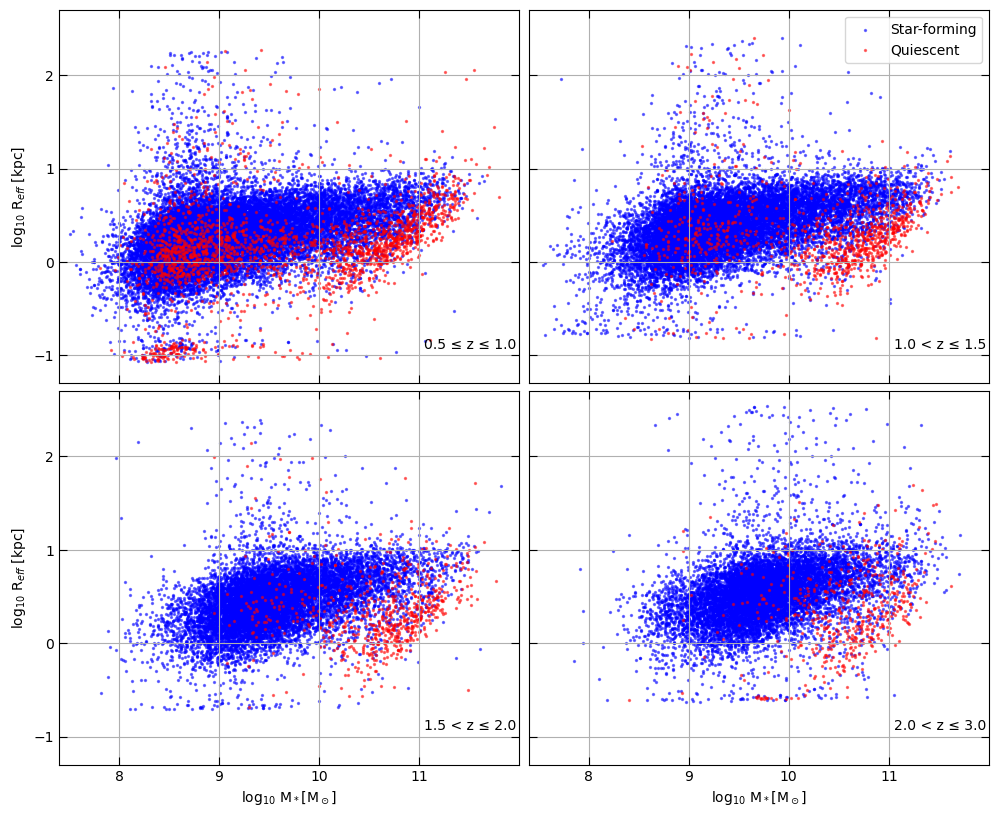

In [182]:
x1_q = lmass[(redshift>=0.5)&(redshift<=1.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
x1_sf = lmass[(redshift>=0.5)&(redshift<=1.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
x2_q = lmass[(redshift>1.0)&(redshift<=1.5)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
x2_sf = lmass[(redshift>1.0)&(redshift<=1.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
x3_q = lmass[(redshift>1.5)&(redshift<=2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
x3_sf = lmass[(redshift>1.5)&(redshift<=2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
x4_q = lmass[(redshift>2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
x4_sf = lmass[(redshift>2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
y1_q = lsize[(redshift>=0.5)&(redshift<=1.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
y1_sf = lsize[(redshift>=0.5)&(redshift<=1.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
y2_q = lsize[(redshift>1.0)&(redshift<=1.5)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
y2_sf = lsize[(redshift>1.0)&(redshift<=1.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
y3_q = lsize[(redshift>1.5)&(redshift<=2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
y3_sf = lsize[(redshift>1.5)&(redshift<=2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
y4_q = lsize[(redshift>2)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
y4_sf = lsize[(redshift>2)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
z1_q = lsize_err[(redshift>=0.5)&(redshift<=1.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
z1_sf = lsize_err[(redshift>=0.5)&(redshift<=1.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
z2_q = lsize_err[(redshift>1.0)&(redshift<=1.5)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
z2_sf = lsize_err[(redshift>1.0)&(redshift<=1.5)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
z3_q = lsize_err[(redshift>1.5)&(redshift<=2.0)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
z3_sf = lsize_err[(redshift>1.5)&(redshift<=2.0)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]
z4_q = lsize_err[(redshift>2)&(UVcol>1.3)&(VJcol<1.6)&(UVcol>(0.88*VJcol+0.69))]
z4_sf = lsize_err[(redshift>2)&((UVcol<1.3)|(VJcol>1.6)|(UVcol<(0.88*VJcol+0.69)))]

def powlaw_high(x,a,b):
    return a*np.power((10**x)/(5e10),b)
def powlaw_full(x,a,b,y,d):
    return (y*((10**x)**a))*((1+((10**x)/(10**d)))**(b-a))

x0_high =[0.45,0.64]
bounds_high = ([-0.5,0],[2,2])
x0_full =[-0.03,1.6,0.48,10.95]
bounds_full = ([-2,0,-10,9],[2,10,10,13])

p1_q,sig_1q = curve_fit(f=powlaw_full, xdata=x1_q, ydata=y1_q, p0=x0_full, bounds=bounds_full)
p1_sf,sig_1sf = curve_fit(f=powlaw_high, xdata=x1_sf, ydata=y1_sf, p0=x0_high, bounds=bounds_high)
p2_q,sig_2q = curve_fit(f=powlaw_full, xdata=x2_q, ydata=y2_q, p0=x0_full, bounds=bounds_full)
p2_sf,sig_2sf = curve_fit(f=powlaw_high, xdata=x2_sf, ydata=y2_sf, p0=x0_high, bounds=bounds_high)
p3_q,sig_3q = curve_fit(f=powlaw_full, xdata=x3_q, ydata=y3_q, p0=x0_full, bounds=bounds_full)
p3_sf,sig_3sf = curve_fit(f=powlaw_high, xdata=x3_sf, ydata=y3_sf, p0=x0_high, bounds=bounds_high)
p4_q,sig_4q = curve_fit(f=powlaw_full, xdata=x4_q, ydata=y4_q, p0=x0_full, bounds=bounds_full)
p4_sf,sig_4sf = curve_fit(f=powlaw_high, xdata=x4_sf, ydata=y4_sf, p0=x0_high, bounds=bounds_high)
#
y1_q_fit = powlaw_full(x1_q,*p1_q)
y1_sf_fit = powlaw_high(x1_sf,*p1_sf)
y2_q_fit = powlaw_full(x2_q,*p2_q)
y2_sf_fit = powlaw_high(x2_sf,*p2_sf)
y3_q_fit = powlaw_full(x3_q,*p3_q)
y3_sf_fit = powlaw_high(x3_sf,*p3_sf)
y4_q_fit = powlaw_full(x4_q,*p4_q)
y4_sf_fit = powlaw_high(x4_sf,*p4_sf)

y1_q_comp = powlaw_full(x1_q,-0.03,1.60,0.48,10.95)
y1_sf_comp = powlaw_high(x1_sf,0.45,0.64)
y2_q_comp = powlaw_full(x2_q,-0.33,1.25,3.24,10.63)
y2_sf_comp = powlaw_high(x2_sf,0.28,0.63)
y3_q_comp = powlaw_full(x3_q,-0.17,1.84,1.76,11.09)
y3_sf_comp = powlaw_high(x3_sf,0.18,0.61)
y4_q_comp = powlaw_full(x4_q,-0.17,1.84,1.76,11.09)
y4_sf_comp = powlaw_high(x4_sf,0.18,0.61)

I = sorted(zip(x1_q,y1_q_fit), key = operator.itemgetter(0))
x1_q_srt, y1_q_srt = zip(*I)
J = sorted(zip(x1_sf,y1_sf_fit), key = operator.itemgetter(0))
x1_sf_srt, y1_sf_srt = zip(*J)
K = sorted(zip(x2_q,y2_q_fit), key = operator.itemgetter(0))
x2_q_srt, y2_q_srt = zip(*K)
L = sorted(zip(x2_sf,y2_sf_fit), key = operator.itemgetter(0))
x2_sf_srt, y2_sf_srt = zip(*L)
M = sorted(zip(x3_q,y3_q_fit), key = operator.itemgetter(0))
x3_q_srt, y3_q_srt = zip(*M)
N = sorted(zip(x3_sf,y3_sf_fit), key = operator.itemgetter(0))
x3_sf_srt, y3_sf_srt = zip(*N)
O = sorted(zip(x4_q,y4_q_fit), key = operator.itemgetter(0))
x4_q_srt, y4_q_srt = zip(*O)
P = sorted(zip(x4_sf,y4_sf_fit), key = operator.itemgetter(0))
x4_sf_srt, y4_sf_srt = zip(*P)

Q = sorted(zip(x1_q,y1_q_comp), key = operator.itemgetter(0))
x1_q_comp, y1_q_comp = zip(*Q)
R = sorted(zip(x1_sf,y1_sf_comp), key = operator.itemgetter(0))
x1_sf_comp, y1_sf_comp = zip(*R)
S = sorted(zip(x2_q,y2_q_comp), key = operator.itemgetter(0))
x2_q_comp, y2_q_comp = zip(*S)
T = sorted(zip(x2_sf,y2_sf_comp), key = operator.itemgetter(0))
x2_sf_comp, y2_sf_comp = zip(*T)
U = sorted(zip(x3_q,y3_q_comp), key = operator.itemgetter(0))
x3_q_comp, y3_q_comp = zip(*U)
V = sorted(zip(x3_sf,y3_sf_comp), key = operator.itemgetter(0))
x3_sf_comp, y3_sf_comp = zip(*V)
W = sorted(zip(x4_q,y4_q_comp), key = operator.itemgetter(0))
x4_q_comp, y4_q_comp = zip(*W)
X = sorted(zip(x4_sf,y4_sf_comp), key = operator.itemgetter(0))
x4_sf_comp, y4_sf_comp = zip(*X)

x1_q_srt = np.asarray(x1_q_srt)
x1_sf_srt = np.asarray(x1_sf_srt)
x2_q_srt = np.asarray(x2_q_srt)
x2_sf_srt = np.asarray(x2_sf_srt)
x3_q_srt = np.asarray(x3_q_srt)
x3_sf_srt = np.asarray(x3_sf_srt)
x4_q_srt = np.asarray(x4_q_srt)
x4_sf_srt = np.asarray(x4_sf_srt)
y1_q_srt = np.asarray(y1_q_srt)
y1_sf_srt = np.asarray(y1_sf_srt)
y2_q_srt = np.asarray(y2_q_srt)
y2_sf_srt = np.asarray(y2_sf_srt)
y3_q_srt = np.asarray(y3_q_srt)
y3_sf_srt = np.asarray(y3_sf_srt)
y4_q_srt = np.asarray(y4_q_srt)
y4_sf_srt = np.asarray(y4_sf_srt)

x1_q_comp = np.asarray(x1_q_comp)
x1_sf_comp = np.asarray(x1_sf_comp)
x2_q_comp = np.asarray(x2_q_comp)
x2_sf_comp = np.asarray(x2_sf_comp)
x3_q_comp = np.asarray(x3_q_comp)
x3_sf_comp = np.asarray(x3_sf_comp)
x4_q_comp = np.asarray(x4_q_comp)
x4_sf_comp = np.asarray(x4_sf_comp)
y1_q_comp = np.asarray(y1_q_comp)
y1_sf_comp = np.asarray(y1_sf_comp)
y2_q_comp = np.asarray(y2_q_comp)
y2_sf_comp = np.asarray(y2_sf_comp)
y3_q_comp = np.asarray(y3_q_comp)
y3_sf_comp = np.asarray(y3_sf_comp)
y4_q_comp = np.asarray(y4_q_comp)
y4_sf_comp = np.asarray(y4_sf_comp)

min_c = min(lssfr[(radius>0.)&(radius<24.)])
max_c = max(lssfr[(radius>0.)&(radius<24.)])

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

ax[0,0].scatter(x1_sf,y1_sf,s=2,c='blue',alpha=0.5,label='Star-forming')
ax[0,0].scatter(x1_q,y1_q,s=2,c='red',alpha=0.5,label='Quiescent')
ax[0,1].scatter(x2_sf,y2_sf,s=2,c='blue',alpha=0.5,label='Star-forming')
ax[0,1].scatter(x2_q,y2_q,s=2,c='red',alpha=0.5,label='Quiescent')
ax[1,0].scatter(x3_sf,y3_sf,s=2,c='blue',alpha=0.5,label='Star-forming')
ax[1,0].scatter(x3_q,y3_q,s=2,c='red',alpha=0.5,label='Quiescent')
ax[1,1].scatter(x4_sf,y4_sf,s=2,c='blue',alpha=0.5,label='Star-forming')
ax[1,1].scatter(x4_q,y4_q,s=2,c='red',alpha=0.5,label='Quiescent')

#ax[0,0].plot(10**x1_q_srt,10**y1_q_srt,c='black')
#ax[0,0].plot(10**x1_sf_srt,10**y1_sf_srt,c='black')
#ax[0,1].plot(10**x2_q_srt,10**y2_q_srt,c='black')
#ax[0,1].plot(10**x2_sf_srt,10**y2_sf_srt,c='black')
#ax[1,0].plot(10**x3_q_srt,10**y3_q_srt,c='black')
#ax[1,0].plot(10**x3_sf_srt,10**y3_sf_srt,c='black')
#ax[1,1].plot(10**x4_q_srt,10**y4_q_srt,c='black')
#ax[1,1].plot(10**x4_sf_srt,10**y4_sf_srt,c='black')

#ax[0,0].plot(10**x1_q_comp,10**y1_q_comp,'--',c='black')
#ax[0,0].plot(10**x1_sf_comp,10**y1_sf_comp,'--',c='black')
#ax[0,1].plot(10**x2_q_comp,10**y2_q_comp,'--',c='black')
#ax[0,1].plot(10**x2_sf_comp,10**y2_sf_comp,'--',c='black')
#ax[1,0].plot(10**x3_q_comp,10**y3_q_comp,'--',c='black')
#ax[1,0].plot(10**x3_sf_comp,10**y3_sf_comp,'--',c='black')
#ax[1,1].plot(10**x4_q_comp,10**y4_q_comp,'--',c='black')
#ax[1,1].plot(10**x4_sf_comp,10**y4_sf_comp,'--',c='black')

ax[0,0].tick_params(which='major', direction='in', length=6)
ax[0,0].tick_params(which='minor', direction='in')
ax[1,0].tick_params(which='major', direction='in', length=6)
ax[1,0].tick_params(which='minor', direction='in')
ax[0,1].tick_params(which='major', direction='in', length=6)
ax[0,1].tick_params(which='minor', direction='in')
ax[1,1].tick_params(which='major', direction='in', length=6)
ax[1,1].tick_params(which='minor', direction='in')

ax[0,0].set_yticks([-1, 0, 1, 2])
ax[0,1].set_xticks([8,9,10,11])
ax[0,1].set_yticks([-1, 0, 1, 2])
ax[1,1].set_xticks([8,9,10,11])

ax[0,0].xaxis.set_ticks_position('both')
ax[0,0].yaxis.set_ticks_position('both')
ax[1,0].xaxis.set_ticks_position('both')
ax[1,0].yaxis.set_ticks_position('both')
ax[0,1].xaxis.set_ticks_position('both')
ax[0,1].yaxis.set_ticks_position('both')
ax[1,1].xaxis.set_ticks_position('both')
ax[1,1].yaxis.set_ticks_position('both')

ax[0,0].set_xlim(7.4,12)
ax[0,1].set_xlim(7.4,12)
ax[1,0].set_xlim(7.4,12)
ax[1,1].set_xlim(7.4,12)

ax[0,0].set_ylim(-1.3,2.7)
ax[0,1].set_ylim(-1.3,2.7)
ax[1,0].set_ylim(-1.3,2.7)
ax[1,1].set_ylim(-1.3,2.7)

ax[0,0].text(11.05,-0.93,'0.5 ≤ z ≤ 1.0')
ax[0,1].text(11.05,-0.93,'1.0 < z ≤ 1.5')
ax[1,0].text(11.05,-0.93,'1.5 < z ≤ 2.0')
ax[1,1].text(11.05,-0.93,'2.0 < z ≤ 3.0')

ax[1,0].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')
ax[1,1].set_xlabel('log$_{10}$ M$_*$[M$_\odot$]')

ax[0,0].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')
ax[1,0].set_ylabel('log$_{10}$ R$_{eff}$ [kpc]')

ax[0,0].grid(True,'minor',alpha=0.1)
ax[0,1].grid(True,'minor',alpha=0.1)
ax[1,0].grid(True,'minor',alpha=0.1)
ax[1,1].grid(True,'minor',alpha=0.1)
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

#ax[0,0].legend()
ax[0,1].legend()
#ax[1,0].legend()
#ax[1,1].legend()

plt.subplots_adjust(wspace=0.02, hspace=0.02)

plt.show()

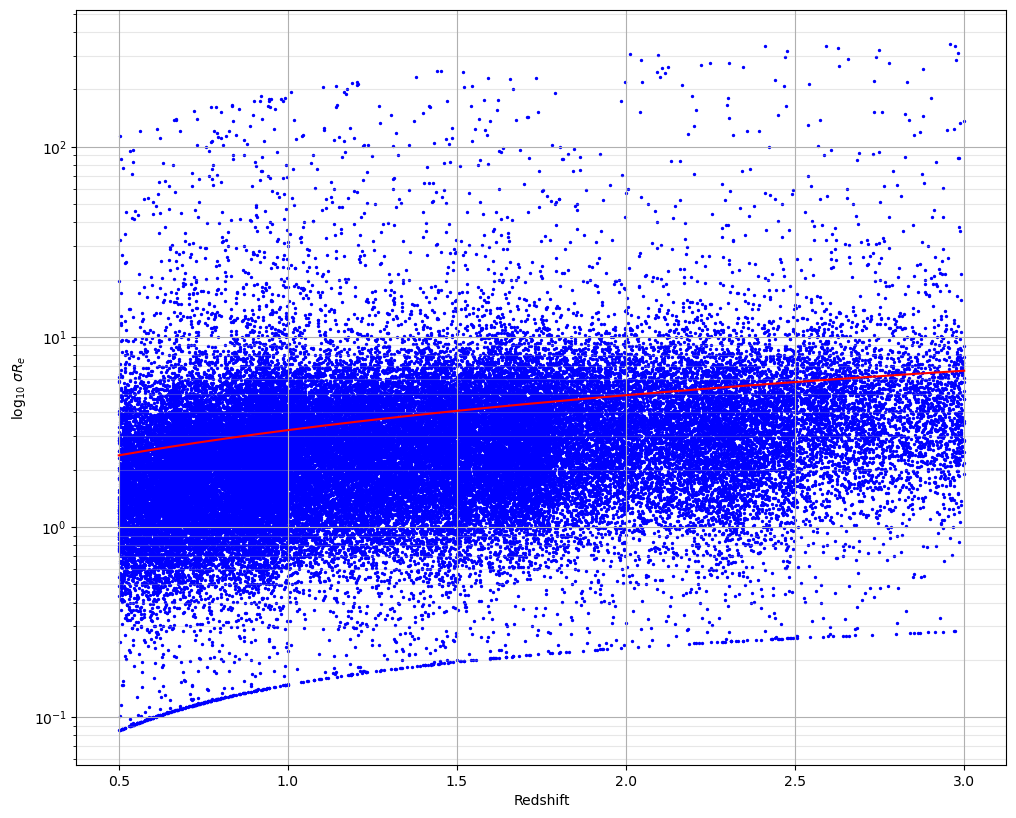

In [23]:
x1 = redshift[(redshift>0.5)&(radius>0.)&(radius<24)&(radius/radius_err>2.)]
y1 = size[(redshift>0.5)&(radius>0.)&(radius<24)&(radius/radius_err>2.)]


a,b = np.polyfit(x1,y1,1)
y1_fit = a*x1 + b

J = sorted(zip(x1,y1_fit), key = operator.itemgetter(0))
x1_sort, y1_sort = zip(*J)

plt.plot(x1_sort,y1_sort,c='red')

plt.scatter(x1,y1,c='blue',s=2)

plt.xlabel("Redshift")
plt.ylabel("log$_{10}$ $\sigma R_e$")

#plt.xscale('log')
plt.yscale('log')

plt.grid(True,'minor',alpha=0.3)

plt.grid()
plt.show()